# Model LSTM for Time Series Forecasting temperature

# LLibreries

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline
import seaborn as sns
import plotly.express as px
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format
import json
import os

# Ignorar warnings
import warnings
warnings.filterwarnings("ignore")


from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Barra de progresso
# from tqdm import tqdm
from tqdm.notebook import tqdm


# TensorFlow i keras per fer LSTM
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM



# Preparació de dades des de JSON 

No cal fer-ho es pot llegir directament des del CSV ja preprocessat


La següent cel·la és per llegir des del CSV

In [15]:
# Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Data/Dades_T_estacions_xema_Z1'
fitxer_dades = 'SCM_T_Z1.json'

path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades)

# Obrir un arxiu json per veure com esta estructurat i com organitzar les dades
with open(path_dades, 'r') as f:
    data = json.load(f)

# Accedemos a las lecturas (temperaturas) del JSON
lecturas = data[0]['variables'][0]['lectures']

# Convertimos las lecturas a un DataFrame con solo las columnas necesarias
df = pd.DataFrame(lecturas)[['data', 'valor']]


# Convertimos la columna 'data' a tipo datetime para análisis posterior
df['data'] = pd.to_datetime(df['data'], utc=True)

df = df.sort_values(by='data')

# Eliminem les dades que estan entre hores, es a dir en minuts que no son 0
df = df[df['data'].dt.minute == 0]

# Restablir l'index
df = df.reset_index(drop=True)

df

,data,valor
0,1998-01-01 00:00:00+00:00,-4.60
1,1998-01-01 01:00:00+00:00,-5.10
2,1998-01-01 02:00:00+00:00,-5.30
3,1998-01-01 03:00:00+00:00,-5.50
4,1998-01-01 04:00:00+00:00,-5.80
...,...,...
230024,2024-12-31 19:00:00+00:00,0.10
230025,2024-12-31 20:00:00+00:00,-0.60
230026,2024-12-31 21:00:00+00:00,-0.60
230027,2024-12-31 22:00:00+00:00,-0.70


# Carregar dades des de CSV

Dades Carregades des del fitxer CSV netejat i guardat pel fitxer de data preprocessing

In [16]:
#Directori de treball

# Ruta on esta el script actual
# __path__ = os.path.dirname(os.path.realpath(__file__)) # Si es fitxer .py
__path__ = os.getcwd() # Si es fitxer .ipynb

carpeta_dades = 'Data/Dades_T_estacions_xema_Z1'
fitxer_dades_csv = 'SCM_T_Z1.csv'

path_dades = os.path.join(__path__, carpeta_dades, fitxer_dades_csv)

# Llegir el fitxer CSV i importar les dades

df = pd.read_csv(path_dades)

# Convertir la columna 'data' a tipus datetime
df['data'] = pd.to_datetime(df['data'], utc=True)

df

,data,valor
0,1998-01-01 00:00:00+00:00,-4.60
1,1998-01-01 01:00:00+00:00,-5.10
2,1998-01-01 02:00:00+00:00,-5.30
3,1998-01-01 03:00:00+00:00,-5.50
4,1998-01-01 04:00:00+00:00,-5.80
...,...,...
230024,2024-12-31 19:00:00+00:00,0.10
230025,2024-12-31 20:00:00+00:00,-0.60
230026,2024-12-31 21:00:00+00:00,-0.60
230027,2024-12-31 22:00:00+00:00,-0.70


In [17]:
# seleccionem les dades LSTM, del 2020 en endavant ja que a partir d'aleshores no tenen cap interrupció
df_lstm = df[df['data'] >= '2020-01-01'].copy()

df_lstm

,data,valor
186181,2020-01-01 00:00:00+00:00,1.30
186182,2020-01-01 01:00:00+00:00,1.60
186183,2020-01-01 02:00:00+00:00,3.20
186184,2020-01-01 03:00:00+00:00,4.40
186185,2020-01-01 04:00:00+00:00,4.00
...,...,...
230024,2024-12-31 19:00:00+00:00,0.10
230025,2024-12-31 20:00:00+00:00,-0.60
230026,2024-12-31 21:00:00+00:00,-0.60
230027,2024-12-31 22:00:00+00:00,-0.70


# Confecció Model

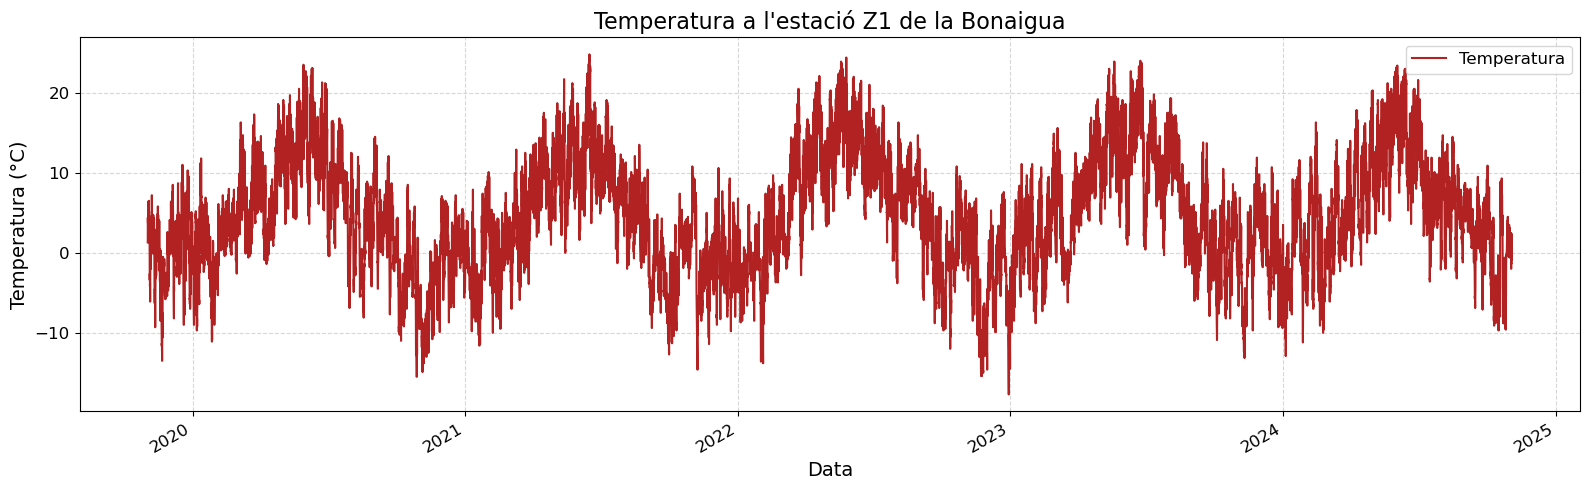

In [ ]:
plt.figure(figsize=(16, 5))
plt.plot(df_lstm['data'], df_lstm['valor'], label='Temperatura', color='firebrick', linewidth=1.5)

# Millores visuals
plt.title('Temperatura a l\'estació Z1 de la Bonaigua', fontsize=16)
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(fontsize=12)

# Format de dates a l’eix X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

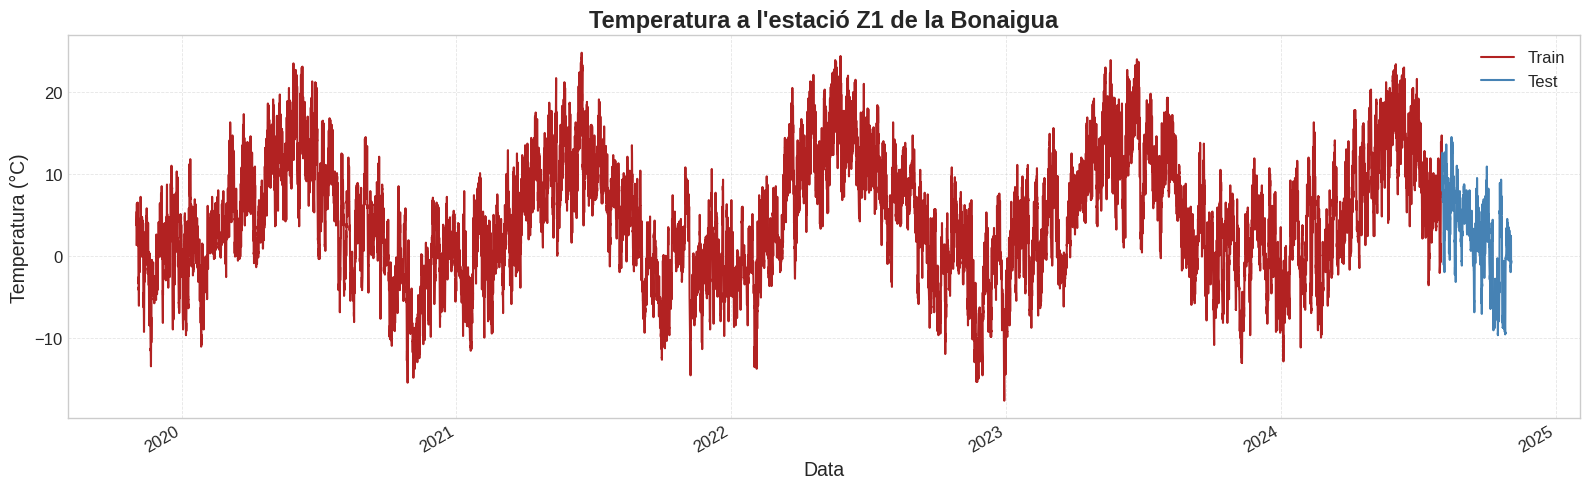

In [147]:
# Separem train i test
# Train fins els últims 3 mesos del conjunt de dades
data_limit_train = df_lstm['data'].max() - pd.DateOffset(months=3)

df_train = df_lstm[df_lstm['data'] <= data_limit_train].copy()
df_test = df_lstm[df_lstm['data'] > data_limit_train].copy()


# Plot de les dades de train i test
plt.figure(figsize=(16, 5))

# Línies de train i test
plt.plot(df_train['data'], df_train['valor'], label='Train', color='firebrick', linewidth=1.5)
plt.plot(df_test['data'], df_test['valor'], label='Test', color='steelblue', linewidth=1.5)

# Estil igual que el que vols
plt.title('Temperatura a l\'estació Z1 de la Bonaigua', fontsize=17, weight='bold')  # 🔸 negreta
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)  # 🔸 graella suau
plt.legend(fontsize=12, frameon=False)  # 🔸 llegenda neta

# Format temporal de l’eix X
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


In [153]:
# Escalem la data

scaler = MinMaxScaler()

df_train['valor_scaled'] = scaler.fit_transform(df_train[['valor']])
df_test['valor_scaled'] = scaler.transform(df_test[['valor']])


In [238]:
display(df_train.head())
display(df_test.head())

,data,valor,valor_scaled
186181,2020-01-01 00:00:00+00:00,1.30,0.45
186182,2020-01-01 01:00:00+00:00,1.60,0.45
186183,2020-01-01 02:00:00+00:00,3.20,0.49
186184,2020-01-01 03:00:00+00:00,4.40,0.52
186185,2020-01-01 04:00:00+00:00,4.00,0.51


,data,valor,valor_scaled
227821,2024-10-01 00:00:00+00:00,8.60,0.62
227822,2024-10-01 01:00:00+00:00,9.70,0.64
227823,2024-10-01 02:00:00+00:00,10.20,0.66
227824,2024-10-01 03:00:00+00:00,10.50,0.66
227825,2024-10-01 04:00:00+00:00,10.40,0.66


In [240]:
# Creem una funció per crear sequences per LSTM d'entrada

def create_sequences(series, window_size):
    X, y = [], []
    for i in range(window_size, len(series)):
        X.append(series[i - window_size:i])
        y.append(series[i])
    return np.array(X), np.array(y)


In [ ]:
WINDOW_SIZE = 24  # provar més tard 48, 72, 168...


# Creem les sequences per LSTM d'entrada i sortida tant per train com per test
# X_train i X_test seran les dades d'entrada, i y_train i y_test seran les etiquetes (valors a predir)

X_train, y_train = create_sequences(df_train['valor_scaled'].values, WINDOW_SIZE)
X_test, y_test = create_sequences(df_test['valor_scaled'].values, WINDOW_SIZE)



In [ ]:
# ➤ LSTM espera una entrada en 3 dimensions:
#    (n_samples, window_size, n_features)
#    On:
#     - n_samples = nombre de finestres que hem generat
#     - window_size = longitud de cada finestra (número de valors consecutius)
#     - n_features = nombre de variables per timestep (en aquest cas, 1 sola: la temperatura)

# Reshape perquè LSTM espera 3 dimensions
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# També adaptem y per si cal
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

In [252]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

In [251]:

# ============================
# Definim el model LSTM
# ============================

model = Sequential([
    # 1a capa LSTM amb 64 neurones (unitats)
    # - return_sequences=True perquè tenim més capes LSTM després
    # - input_shape = (timesteps, features) → cada seqüència té X valors de temperatura (1 feature)
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),

    # Dropout per reduir overfitting (desactiva aleatòriament un 20% de les neurones durant l'entrenament)
    Dropout(0.2),

    # 2a capa LSTM (encara retorna seqüències per passar-les a la següent LSTM)
    LSTM(64, return_sequences=True),
    Dropout(0.2),

    # 3a capa LSTM (última → no retorna seqüència, només la sortida final)
    LSTM(64),
    Dropout(0.2),

    # Capa de sortida Dense:
    # - 1 neurona perquè fem una predicció escalar (una sola temperatura)
    Dense(1)
])

# Compilació del model:
# - Optimitzador Adam → ajusta els pesos de forma eficient
# - Funció de pèrdua MSE → ideal per problemes de regressió com el nostre
model.compile(
    optimizer='adam',
    loss='mse'
)


In [253]:

# Callback EarlyStopping per aturar l'entrenament si no millora el val_loss
early_stop = EarlyStopping(
    monitor='val_loss',      # monitoritza la pèrdua de validació
    patience=5,              # espera 5 epochs sense millora abans d'aturar
    restore_best_weights=True  # recupera els pesos del millor epoch
)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),  # validació amb dades de test separades
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - loss: 0.0113 - val_loss: 0.0012
Epoch 2/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0023 - val_loss: 8.3778e-04
Epoch 3/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0013 - val_loss: 4.0374e-04
Epoch 4/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 9.4528e-04 - val_loss: 3.4688e-04
Epoch 5/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - loss: 7.8563e-04 - val_loss: 3.4817e-04
Epoch 6/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - loss: 7.2884e-04 - val_loss: 4.9132e-04
Epoch 7/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - loss: 7.2486e-04 - val_loss: 3.3058e-04
Epoch 8/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 25s 19ms/step - loss: 6.9609e-04 - val_loss: 3.2073e-04
Epoch 9/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 24s 19ms/step - loss: 6.7248e-04 - val_loss: 5.3127e-04
Epoch 10/50
1301/1301 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 6.6844e-04 - val_loss: 3.3576e-04
Epoch 11/50
1301/1301 ━━━━━━━━━━━━━

In [254]:
# Avaluació de la pèrdua final al test
test_loss = model.evaluate(X_test, y_test)
print(f"Pèrdua al test: {test_loss}")


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 3.2783e-04
Pèrdua al test: 0.00032072863541543484


In [257]:
# 1. Predicció amb el model
y_pred = model.predict(X_test)

# 2. Desescalar prediccions i valors reals
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

# 3. Afegim la predicció al df_test original
window_size = X_test.shape[1]

# Obtenim l'índex de les files que sí tenen predicció (les que venen després dels primers window_size)
idx_valid = df_test.index[window_size:]

# Afegim la columna 'prediccio' només a les files corresponents
df_test.loc[idx_valid, 'prediccio'] = y_pred_rescaled.flatten()


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [258]:
df_test

,data,valor,valor_scaled,prediccio
227821,2024-10-01 00:00:00+00:00,8.60,0.62,NaN
227822,2024-10-01 01:00:00+00:00,9.70,0.64,NaN
227823,2024-10-01 02:00:00+00:00,10.20,0.66,NaN
227824,2024-10-01 03:00:00+00:00,10.50,0.66,NaN
227825,2024-10-01 04:00:00+00:00,10.40,0.66,NaN
...,...,...,...,...
230024,2024-12-31 19:00:00+00:00,0.10,0.42,-0.62
230025,2024-12-31 20:00:00+00:00,-0.60,0.40,0.10
230026,2024-12-31 21:00:00+00:00,-0.60,0.40,-0.58
230027,2024-12-31 22:00:00+00:00,-0.70,0.40,-0.66


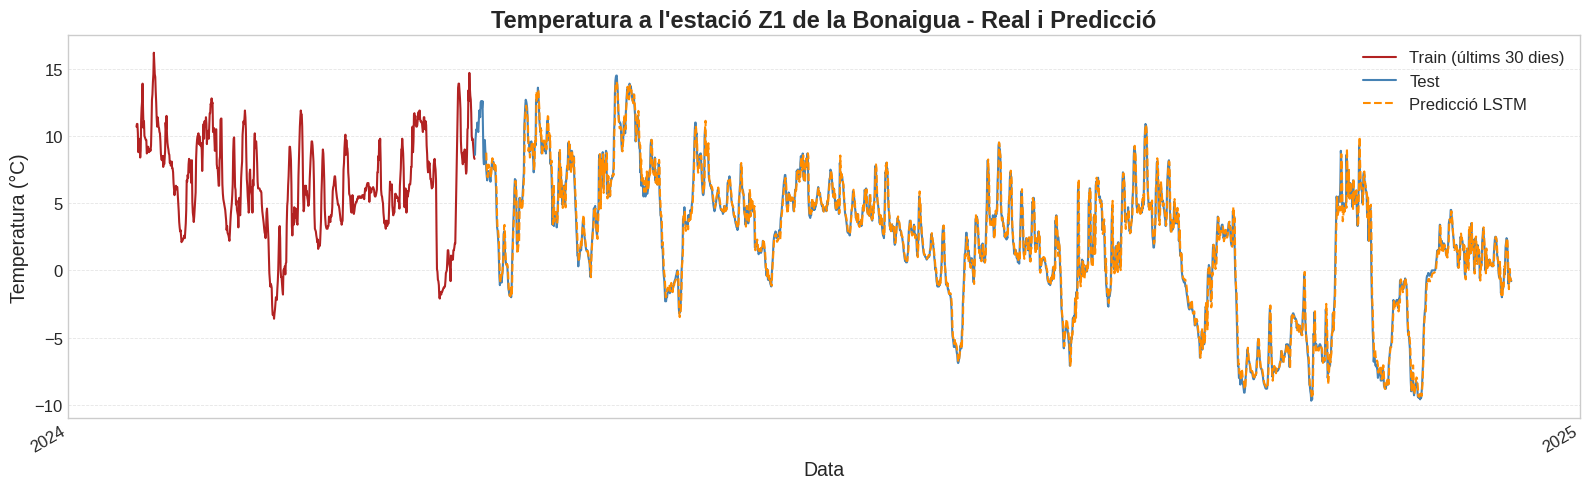

In [262]:

# Defineix quants dies enrere vols mostrar
dies_enrere = 30

# Data límit per filtrar els últims dies del train
data_limit = df_train['data'].max() - pd.Timedelta(days=dies_enrere)

# Filtra el train per només els últims dies
df_train_filtrat = df_train[df_train['data'] >= data_limit]

# Gràfic
plt.figure(figsize=(16, 5))

# Últims dies del train
plt.plot(df_train_filtrat['data'], df_train_filtrat['valor'], label='Train (últims 30 dies)', color='firebrick', linewidth=1.5)

# Test sencer
plt.plot(df_test['data'], df_test['valor'], label='Test', color='steelblue', linewidth=1.5)

# Predicció
plt.plot(df_test['data'], df_test['prediccio'], label='Predicció LSTM', color='darkorange', linewidth=1.5, linestyle='--')

plt.title('Temperatura a l\'estació Z1 de la Bonaigua - Real i Predicció', fontsize=17, weight='bold')
plt.xlabel('Data', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5, linewidth=0.6)
plt.legend(fontsize=12, frameon=False)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


RMSE: 0.7611281260983915
MAE: 0.5141278006538913


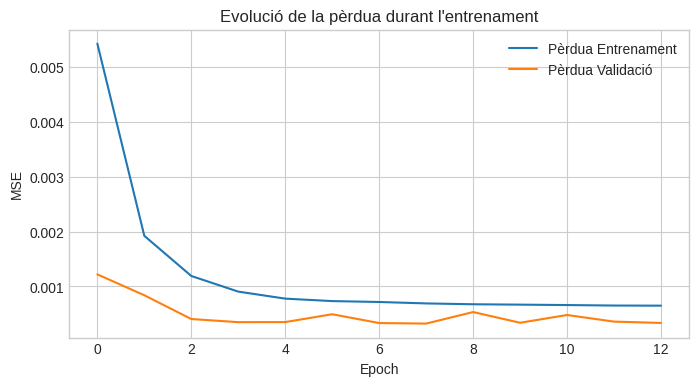

In [266]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Pèrdua Entrenament')
plt.plot(history.history['val_loss'], label='Pèrdua Validació')
plt.title('Evolució de la pèrdua durant l\'entrenament')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)
plt.show()
